In [1]:
import warnings
warnings.filterwarnings("ignore")
from header.Pytorch.dataset import MyDataset
from header.Pytorch.Wavenet_model import Wavenet
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [3]:
if __name__ == '__main__':
    
    # Read data
    label = 'label'
    date_idx = 'tmp_index_ts_value_20200430_henry.tx_dt'
    df = pd.read_csv('./csv_dataset/data_prepro_0814.csv').dropna(axis = 0).reset_index(drop = True)
    
    # Some parameter
    lag = 44
    gap = 22
    normalize_method = 'min-max'
    
    # -----------Train--------------
    Train = MyDataset(df, label_idx = label, date_idx = date_idx, lag = lag, gap = gap,
                      normalize_method = normalize_method, start = None, end = '2015-10-01')
    
    train_loader = DataLoader(dataset=Train, batch_size=128, 
                              shuffle=True, num_workers=8)
    
    print('Train the model from {} to {}.\n'.format(Train.target_dt[0], Train.target_dt[-1]))
    
    Val = MyDataset(df, label_idx = label, date_idx = date_idx, lag = lag, gap = gap,
                    normalize_method = normalize_method, start = '2015-10-01', end = '2017-09-29')
    
    print('Validation set: from {} to {}.\n'.format(Val.target_dt[0], Val.target_dt[-1]))
    
    # ------------Test---------------
    Test = MyDataset(df, label_idx = label, date_idx = date_idx, lag = lag, gap = gap,
                     normalize_method = normalize_method, start = '2017-09-29', end = None)
    
    print('Test the model from {} to {}.\n'.format(Test.target_dt[0], Test.target_dt[-1]))

(2594, 103, 44) (2594, 1)
Train the model from 2005-10-21 to 2015-09-30.

(455, 103, 44) (455, 1)
Validation set: from 2016-01-01 to 2017-09-28.

(551, 103, 44) (551, 1)
Test the model from 2018-01-01 to 2020-02-25.



In [9]:
model = Wavenet(time_step = 44, feature_num = 103, num_blocks = 4,
                num_layers = 3, output_channel = 103, kernel_size = 2)

model.set_device()

loss_func = nn.BCELoss()#nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.8, last_epoch=-1)

train_info, val_info = model.Train(dataloader = train_loader, loss_func = loss_func,
                                   optimizer = optimizer, scheduler = scheduler,
                                   Val = Val, num_epochs = 40, disp_interval = 1)

receptive_field: 29
Output width: 16

Start to train......
Epoch 1 / 40
Learning Rate: [0.001]
Training Loss: 0.6829, Accuracy: 0.4926
Validation Loss: 0.6278, Accuracy: 0.6440
------------------------------

Epoch 2 / 40
Learning Rate: [0.001]
Training Loss: 0.6455, Accuracy: 0.5525
Validation Loss: 0.6069, Accuracy: 0.6725
------------------------------

Epoch 3 / 40
Learning Rate: [0.001]
Training Loss: 0.6375, Accuracy: 0.5688
Validation Loss: 0.6323, Accuracy: 0.6198
------------------------------

Epoch 4 / 40
Learning Rate: [0.001]
Training Loss: 0.6173, Accuracy: 0.5923
Validation Loss: 0.6002, Accuracy: 0.6835
------------------------------

Epoch 5 / 40
Learning Rate: [0.001]
Training Loss: 0.6078, Accuracy: 0.5826
Validation Loss: 0.6122, Accuracy: 0.6527
------------------------------

Epoch 6 / 40
Learning Rate: [0.001]
Training Loss: 0.5952, Accuracy: 0.6005
Validation Loss: 0.6112, Accuracy: 0.6681
------------------------------

Epoch 7 / 40
Learning Rate: [0.001]
Train

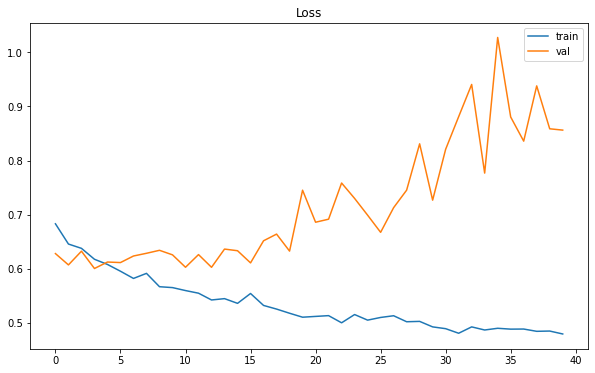

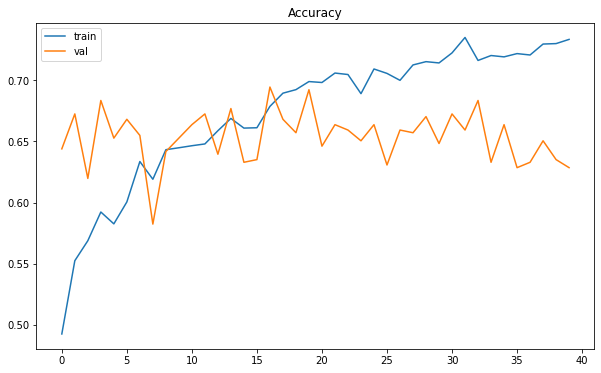

In [10]:
plt.figure(figsize = (10, 6))
plt.title('Loss')
plt.plot(train_info['loss'], label = 'train')
plt.plot(val_info['loss'], label = 'val')
plt.legend()
plt.show()

plt.figure(figsize = (10, 6))
plt.title('Accuracy')
plt.plot(train_info['acc'], label = 'train')
plt.plot(val_info['acc'], label = 'val')
plt.legend()
plt.show()

In [11]:
test_model = torch.load('./Pytorch_model_ckpt/Wavenet.pkl')
test_model.to('cpu')
test_model.eval()
x_test, y_test = Test[:]
pred = test_model(x_test)
y_test = y_test.detach().numpy().reshape(-1)
pred = pred.detach().numpy().reshape(-1)
pred = np.round(pred)
print(classification_report(y_test, pred))

pred = model(x_test)
pred = pred.detach().numpy().reshape(-1)
pred = np.round(pred)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.57      0.36      0.44       273
         1.0       0.54      0.74      0.62       278

    accuracy                           0.55       551
   macro avg       0.56      0.55      0.53       551
weighted avg       0.56      0.55      0.53       551



In [ ]:
true = np.sum(y_test == 1)
false = np.sum(y_test == 0)
print("(y == 1) : (y == 0) = {} : {}".format(true, false))
print("(y == 1)/(y == 0) = {}".format(true/false))

In [41]:
result = pd.DataFrame()
result['tx_dt'] = Test.tx_dt
result['Pytorch_Wavenet_without_rolling_pred'] = pred
result['Pytorch_Wavenet_rolling_pred'] = a
result['label'] = y_test
result['target_dt'] = Test.target_dt

In [43]:
result.to_csv('./benchmark.csv', index = False)

In [42]:
result

,tx_dt,Pytorch_Wavenet_without_rolling_pred,Pytorch_Wavenet_rolling_pred,label,target_dt
0,2017-11-30,1.0,1.0,1.0,2018-01-01
1,2017-12-01,1.0,1.0,1.0,2018-01-02
2,2017-12-04,0.0,1.0,1.0,2018-01-03
3,2017-12-05,1.0,1.0,1.0,2018-01-04
4,2017-12-06,0.0,1.0,1.0,2018-01-05
...,...,...,...,...,...
546,2020-01-15,0.0,0.0,0.0,2020-02-19
547,2020-01-16,1.0,0.0,0.0,2020-02-20
548,2020-01-17,1.0,1.0,0.0,2020-02-21
549,2020-01-20,1.0,0.0,0.0,2020-02-24
